<a href="https://colab.research.google.com/github/subhobrata/semantic-segmentation/blob/master/Copy_of_Deeplab_v3_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deeplab_v3 
The aim of this project is to show how easy it is to build complex models using tf.keras. This work is heavily inspired from this repo. In fact, we are using the weights from that repo, hence I will keep the name of the layers as in the original repo. This ensures that the weights are loaded in the model in a neat way layer by layer. 

Also, we will be using `MobileNet_v2` as the backbone architecture. 

In [2]:
from google.colab import files
uploaded = files.upload() 

Saving messi5.jpg to messi5.jpg


In [4]:
!mkdir ~/temp_data
!cp *.jpg ~/temp_data/
!cp deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5 ~/temp_data/

mkdir: cannot create directory ‘/root/temp_data’: File exists


## Import required libraries

In [0]:
import warnings 
warnings.filterwarnings("ignore")

import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from skimage.io import imread


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, Add, Concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.utils import get_file

## Custom layer in tf.keras for upsampling

In [0]:
class BilinearUpsampling(Layer):
    """
    This layer is used for upsampling via bilinear 
    interpolation. UpSampling2D layer wasn't enough 
    as it doesn't provide the `align_corners` parameter
    which is pretty much required here
    
    Args:
    upsampling: tuple of two numbers for upsampling operation
                (2,2) by default
                
    output_size: required output size as a result
    Either upsampling or output_size is required. Apart from 
    __init__ the following methods have to be implemented for
    any custom layer.
    1) compute_output_shape
    2) call
    3) get_config
    
    """
    
    def __init__(self, 
                 upsampling=(2,2), 
                 output_size=None,**kwargs):
        
      # call the constructor of base class
      super(BilinearUpsampling, self).__init__(**kwargs)
      self.input_spec = InputSpec(ndim=4)

      # check if output_size or sampling is provided
      if output_size:
          self.upsampling = None
          self.output_size = tuple(output_size)
      else:
          self.output_size = None
          self.upsampling = tuple(upsampling)

    
    
    def compute_output_shape(self, input_shape):
      if self.upsampling:
          if input_shape[1] is not None:
              height = self.upsampling[0]*input_shape[1]  
          else: 
              hieght = None

          if input_shape[2] is not None:
              width = self.upsampling[1]*input_shape[2]  
          else: 
              width= None
      else:
          height = self.output_size[0]
          width = self.output_size[1]

      return (input_shape[0],
              height,
              width,
              input_shape[3])
    
    

    def call(self, inputs):
      if self.upsampling:
          return tf.image.resize(inputs, 
                                 (inputs.shape[1] * self.upsampling[0],
                                 inputs.shape[2] * self.upsampling[1]),
                                 align_corners=True)
      else:
          return tf.image.resize(inputs, 
                                 (self.output_size[0],
                                  self.output_size[1]),
                                  align_corners=True)
    
    
    def get_config(self):
      config = {'upsampling': self.upsampling,
                'output_size': self.output_size}
      base_config = super(BilinearUpsampling, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

In mobilenet_v2, we need to make sure that the number of channels in each layer is divisible by 8. This becomes important when the width multiplier `alpha` is not equal to `1.0`. This function is taken from the original tf implementation which can be found [here](https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py) 

**Note:** In this implementation, we will be using `alpha=1.0` only. You can play with other values of alpha if you want to.

## Helper functions and some (pseudo) constants

In [0]:
def _make_divisible(v, divisor, min_value=None):
  if min_value is None:
      min_value = divisor
  new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
  # Make sure that round down does not go down by more than 10%.
  if new_v < 0.9 * v:
      new_v += divisor
  return new_v

In [0]:
# some constants

# shape of the input image
img_input_shape = (512, 512, 3)

# width multiplier for mobilenetv2 
alpha = 1

# output stride
output_stride = 8

# number of classes
nb_classes=21   # VOC classes

if nb_classes == 21:
    last_layer_name = 'logits_semantic'
else:
    last_layer_name = 'custom_logits_semantic'

# filters in first conv block
first_block_filters = _make_divisible(32 * alpha, 8)

# size of pooling window
avg_pool_size = (int(np.ceil(img_input_shape[0] / output_stride)), 
                 int(np.ceil(img_input_shape[1] / output_stride)))

# weights of the pre-trained model
weights ='/root/temp_data/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5'

Next we will define the most important part of mobilenetv2: `inverted residual block`. Inverted residual block is where the `squeeze => expand => squeeze` operation happens. Inverted residual blocks helps reducing the number of parameters drastically as compared to mobilenetv1 while giving the same/better performance. This image taken from **Google Images** is the best way to understand this operation:

![MobileNetv2](https://raw.githubusercontent.com/MG2033/MobileNet-V2/master/figures/irc.png)

## Modelling

In [0]:
def _inverted_residual_block(inputs,
                              expansion,   
                              filters,
                              stride,
                              alpha,
                              block_id,
                              skip_connection,
                              rate=1):
    """
    This function implements the inverted residual block 
    defined in mobilenetv2.
    
    Args:
        inputs: A 4-D tensor of shape (batch_size, h, w, c)
        expansion: Amount of depth to be extended
        filters: number of filters to apply
        stride: kernel size
        alpha: width multiplier
        block_id: name to be given to this block
        skip_connection: whether to have a skip connection or not
        rate: dialtion rate to be used in conv blocks
        
    """
    
    in_channels = inputs.shape[-1].value
    pointwise_conv_filters = int(filters*alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    
    if block_id:
        prefix = 'expanded_conv_{}_'.format(block_id)
    else:
        prefix = 'expanded_conv_'
    
    # Input 
    x = inputs
    
    if block_id:
        # 1x1 conv block
        x = Conv2D(expansion * in_channels, 
                    kernel_size=1, 
                    padding='same',
                    use_bias=False, 
                    activation=None,
                    name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, 
                               momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    
    
    # Depthwise 3X3 block
    x = DepthwiseConv2D(kernel_size=3, 
                        strides=stride, 
                        activation=None,
                        use_bias=False, 
                        padding='same', 
                        dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, 
                           momentum=0.999, 
                           name=prefix + 'depthwise_BN')(x)
    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    
    # Project-> 1X1 Conv with no activation
    x = Conv2D(pointwise_filters,
               kernel_size=1, 
               padding='same', 
               use_bias=False, 
               activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, 
                           momentum=0.999, 
                           name=prefix + 'project_BN')(x)
    
    
    # skip connection
    if skip_connection:
        x = Add(name=prefix + 'add')([inputs, x])
        
    return x

In [0]:
def get_inv_blocks_params():
  inv_block_params = namedtuple('ib_params', ['id', 
                                              'filters', 
                                              'expansion', 
                                              'stride', 
                                              'rate', 
                                              'skip_conn'])

  # There are a total of 16 inverted residual blocks with different params 
  # Hence we will create 16 instances of the above namedtuple
  ib0 = inv_block_params(0, 16, 1, 1, 1, False)
  ib1 = inv_block_params(1, 24, 6, 2, 1, False)
  ib2 = inv_block_params(2, 24, 6, 1, 1, True)
  ib3 = inv_block_params(3, 32, 6, 2, 1, False)
  ib4 = inv_block_params(4, 32, 6, 1, 1, True)
  ib5 = inv_block_params(5, 32, 6, 1, 1, True)
  ib6 = inv_block_params(6, 64, 6, 1, 1, False)
  ib7 = inv_block_params(7, 64, 6, 1, 2, True)
  ib8 = inv_block_params(8, 64, 6, 1, 2, True)
  ib9 = inv_block_params(9, 64, 6, 1, 2, True)
  ib10 = inv_block_params(10, 96, 6, 1, 2, False)
  ib11 = inv_block_params(11, 96, 6, 1, 2, True)
  ib12 = inv_block_params(12, 96, 6, 1, 2, True)
  ib13 = inv_block_params(13, 160, 6, 1, 2, False)
  ib14 = inv_block_params(14, 160, 6, 1, 4, True)
  ib15 = inv_block_params(15, 160, 6, 1, 4, True)
  ib16 = inv_block_params(16, 320, 6, 1, 4, False)

  # Put everything in a list
  ib_params = [ib0, ib1, ib2, ib3, ib4, ib5, ib6, ib7, ib8, ib9,
               ib10, ib11, ib12, ib13, ib14, ib15, ib16]

  # return the list of params
  return ib_params

In [0]:
# First block: Conv3X3 -> BN -> relu6
def get_first_block():
  img_input = Input(shape=img_input_shape, dtype=tf.float32)
  x = Conv2D(first_block_filters, (3,3), 
             strides=(2, 2), 
             padding='same', 
             use_bias=False, 
             name='Conv')(img_input)
  x = BatchNormalization(epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
  x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)
  return img_input, x
  
##############################################################################


# Inverted residual blocks
def get_inverted_residual_blocks(x):
  # get parameters for each inverted block
  ib_params = get_inv_blocks_params()

  # stack inverted residual blocks
  for ib in ib_params:
    block_id = ib.id
    expansion, filters = ib.expansion, ib.filters
    stride, rate = ib.stride, ib.rate
    skip_conn = ib.skip_conn

    x = _inverted_residual_block(inputs=x, 
                                 filters=filters, 
                                 stride=stride, 
                                 rate=rate,
                                 alpha=alpha,
                                 expansion=expansion, 
                                 block_id=block_id, 
                                 skip_connection=skip_conn)
  return x

##############################################################################

# ASPP block
def get_aspp_block(x):
  b4 = AveragePooling2D(pool_size=avg_pool_size)(x)
  b4 = Conv2D(256, 1, padding='same', use_bias=False, name='image_pooling')(b4)
  b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
  b4 = Activation('relu')(b4)
  b4 = BilinearUpsampling((avg_pool_size[0], avg_pool_size[1]))(b4)

  # simple 1x1
  b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
  b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
  b0 = Activation('relu', name='aspp0_activation')(b0)    

  # concatenate the 
  x = Concatenate()([b4, b0])

  return x

##############################################################################

# last conv block
def get_final_block(x):
  x = Conv2D(256, (1, 1), 
             padding='same', 
             use_bias=False, 
             name='concat_projection')(x)
  x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
  x = Activation('relu')(x)

  x = Conv2D(nb_classes, (1, 1), padding='same', name=last_layer_name)(x)
  x = BilinearUpsampling(output_size=(img_input_shape[0], 
                                      img_input_shape[1]))(x)
  return x

In [12]:
# Build first block
img_input, x = get_first_block()

# Build inverted residual blocks
x = get_inverted_residual_blocks(x)

# Build the ASPP block
x = get_aspp_block(x)

# Final block with outputs
output = get_final_block(x)

# Final model
model = Model(img_input, output, name='deeplabv3plus')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalizationV1)  (None, 256, 256, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 256, 256, 32) 0           Conv_BN[0][0]                    
_____________________________________

## Load weights

In [0]:
# set the weights of the model
model.load_weights(weights, by_name=True)

## Test the model

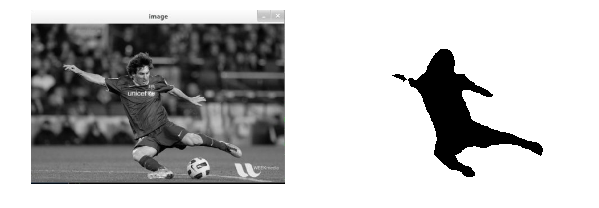

In [15]:
# Sample predictions
img = imread('/root/temp_data/messi5.jpg')
h, w, _ = img.shape
ratio = 512. / np.max([w,h])

resized = cv2.resize(img,(int(ratio*w),int(ratio*h)))
pad_x = int(512 - resized.shape[0])

resized1 = resized / 127.5 - 1.
resized2 = np.pad(resized1,((0,pad_x),(0,0),(0,0)),mode='constant')

res = model.predict(np.expand_dims(resized2,0))
labels = np.argmax(res.squeeze(),-1)
labels = labels[:-pad_x]

f,ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(resized)
ax[0].axis('off')
ax[1].imshow(labels)
ax[1].axis('off')
plt.show()

## References 
1. https://github.com/bonlime/keras-deeplab-v3-plus
2. https://github.com/tensorflow/models/tree/master/research/deeplab
3. https://arxiv.org/abs/1706.05587